# Predicting S&P500 Next Day's Price

**Objective:** predicting the S&P500 index next day price using time series features 

**Libraries used for time series predictions & model tuning:**
- feature_engine
- sklearn

**Models tested:**
- Naive Forecaster
- Random Forest
- Linear Regression Lasso


# Importing Libraries

In [1]:
!pip install yfinance
!pip install feature_engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 5.4 MB/s eta 0:00:00a 0:00:01


In [2]:
import numpy as np 
import pandas as pd 
import lightgbm as lgb
import yfinance as yf
import matplotlib.pyplot as plt
import warnings

#feature engine library
from feature_engine.creation import CyclicalFeatures

#Modeling libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [3]:
#turn off warnings
warnings.filterwarnings("ignore")

# Importing Data

In [4]:
TICKER = "^GSPC"

In [5]:
SP500 = yf.download(tickers=TICKER, 
                   period="max",
                   interval="1d",
                   keepna=False,
                   rounding=True)[["Close"]]

[*********************100%***********************]  1 of 1 completed


In [6]:
SP500

,Close
Date,
1927-12-30,17.66
1928-01-03,17.76
1928-01-04,17.72
1928-01-05,17.55
1928-01-06,17.66
...,...
2023-03-27,3977.53
2023-03-28,3971.27
2023-03-29,4027.81


# Exploratory Data Analysis

**Start & end dates**

In [7]:
start_date = (SP500.index.min()).date()
end_date = (SP500.index.max()).date()

In [8]:
print("The start date is : ",
      start_date,
      "The end date is:",
      end_date, sep="\n")

The start date is : 
1927-12-30
The end date is:
2023-03-31


**Verifying that the index is in datatime format**

In [9]:
type(SP500.index)

pandas.core.indexes.datetimes.DatetimeIndex

**Reducing time period to start from 2000**

In [10]:
SP500 = SP500.loc["2000-01-01":]

In [11]:
SP500.index.min()

Timestamp('2000-01-03 00:00:00')

**Check Missing Values**

In [12]:
SP500.isnull().sum()

Close    0
dtype: int64

**Basic plot of the prices time series**

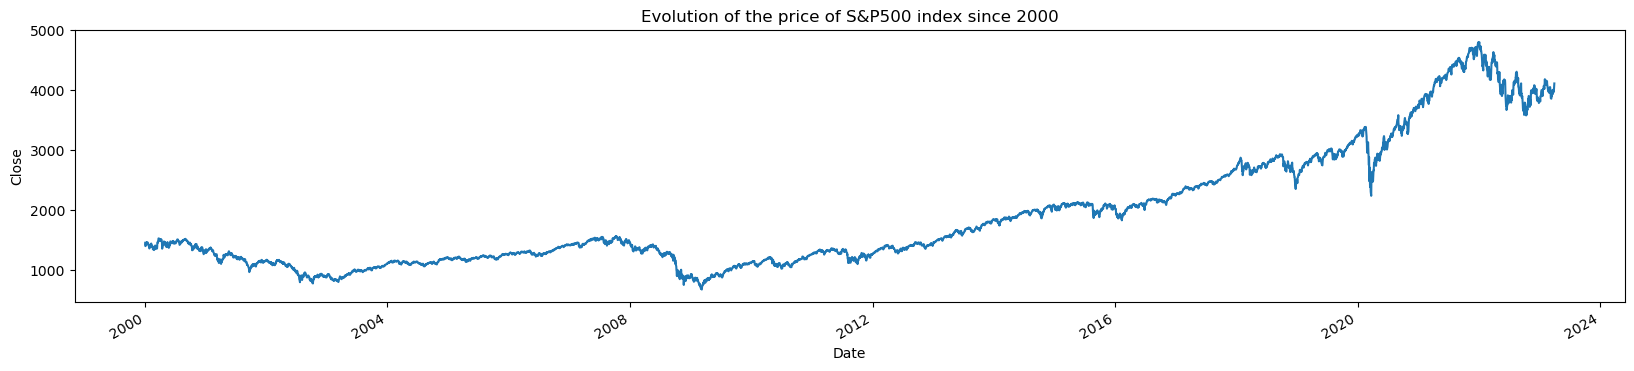

In [13]:
column = "Close"

# Plot the time series
SP500[column].plot(figsize=(20, 4))

# Add title
plt.title("Evolution of the price of S&P500 index since 2000")

# the y axis label
plt.ylabel(column)

plt.show()



*Clearly, we can see a positive trend in the S&P500 since 200, despite the recent decrease.*

## Seasonality

**Basic plot of the average price per month to check monthly seasonality**

In [14]:
#Getting the month of each date and verifying the correct form
month_ = SP500.index.month
month_ = pd.Series(month_, index=SP500.index)
month_.head()


Date
2000-01-03    1
2000-01-04    1
2000-01-05    1
2000-01-06    1
2000-01-07    1
Name: Date, dtype: int64

Text(0, 0.5, 'Price')

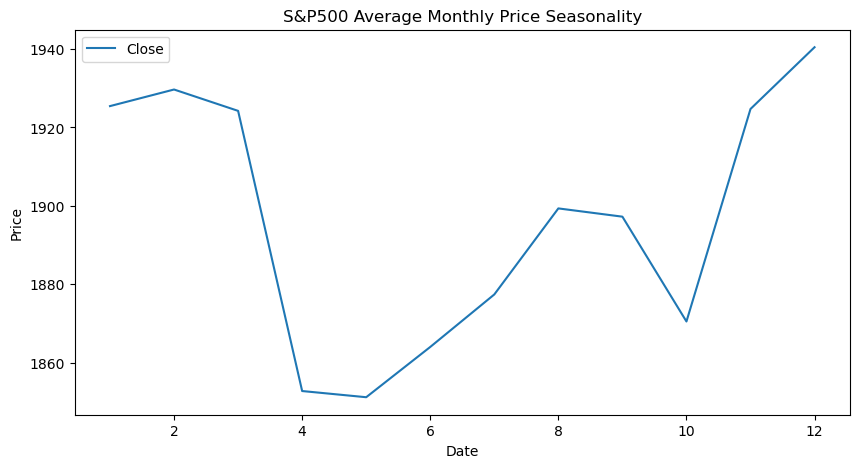

In [15]:
# Plot the average S&P500 price per month
SP500.groupby(month_)[["Close"]].mean().plot(figsize=(10, 5))
plt.title("S&P500 Average Monthly Price Seasonality")
plt.ylabel("Price")


*Interesting results: on average, starting on January prices go up till February then they go drastically down till end of April. April to May, the average prices are flat, and then starting by end of May, the prices go significantly up. August tp September the prices start slightly to decrease, then significan sharp decline till October. The last two month of the year, the average prices go up sharply.*

**Basic plot of the average price per quarter to check quarter seasonality**

In [16]:
#Getting the quarter of each date and verifying the correct form
quarter_ = SP500.index.quarter
quarter_ = pd.Series(quarter_, index=SP500.index)
quarter_.head()

Date
2000-01-03    1
2000-01-04    1
2000-01-05    1
2000-01-06    1
2000-01-07    1
Name: Date, dtype: int64

Text(0, 0.5, 'Price')

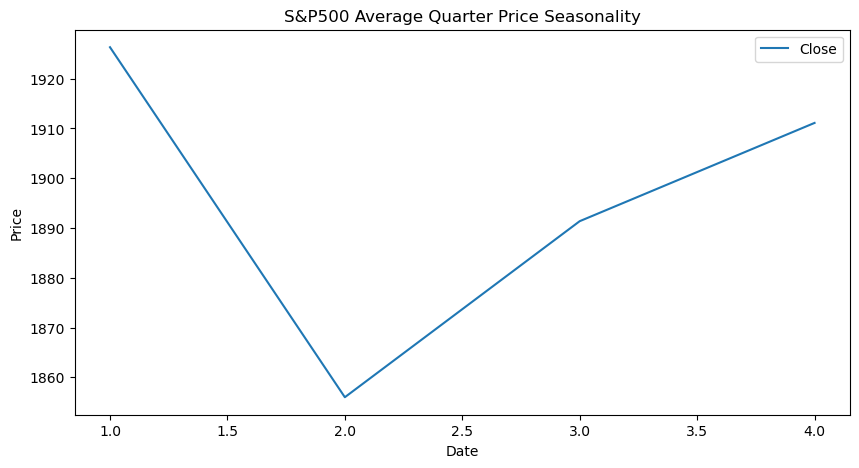

In [17]:
# Plot the average S&P500 price per quarter
SP500.groupby(quarter_)[["Close"]].mean().plot(figsize=(10, 5))
plt.title("S&P500 Average Quarter Price Seasonality")
plt.ylabel("Price")


*Interesting results: quarter 2 has the lowest mean price while first and last quarter have the highest mean price.*

**Basic plot of the average price per week to check weekly seasonality**

In [18]:
#Getting the week of the month of each date and verifying the correct form
weekofmonth_ = (SP500.index.day-1)//7+1

weekofmonth_ = pd.Series(weekofmonth_, index=SP500.index)
weekofmonth_.head()

Date
2000-01-03    1
2000-01-04    1
2000-01-05    1
2000-01-06    1
2000-01-07    1
Name: Date, dtype: int64

Text(0, 0.5, 'Price')

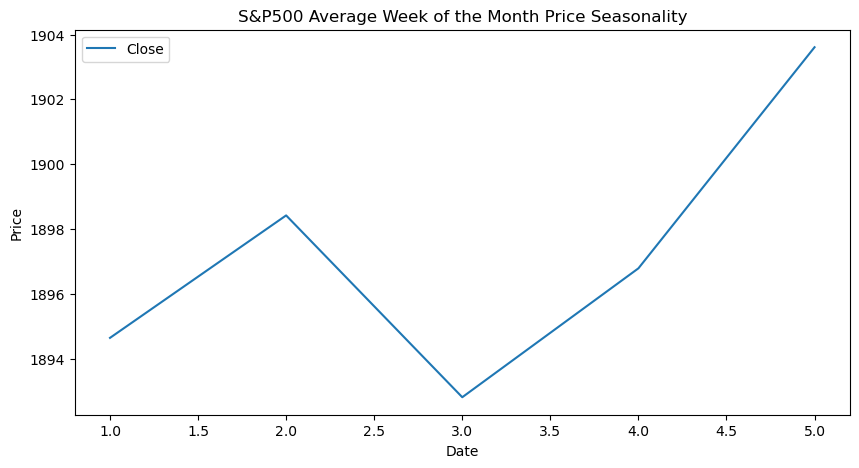

In [19]:
# Plot the average S&P500 price per month
SP500.groupby(weekofmonth_ )[["Close"]].mean().plot(figsize=(10, 5))
plt.title("S&P500 Average Week of the Month Price Seasonality")
plt.ylabel("Price")


**Basic plot of the average price per day of week to check daily seasonality**

In [20]:
day_ = SP500.index.day_of_week
day_ = pd.Series(day_, index=SP500.index)
day_.head()

Date
2000-01-03    0
2000-01-04    1
2000-01-05    2
2000-01-06    3
2000-01-07    4
Name: Date, dtype: int64

Text(0, 0.5, 'Price')

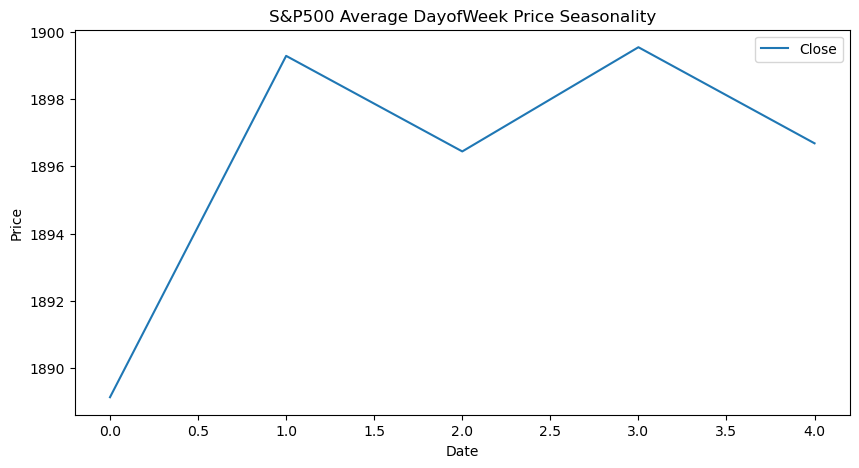

In [21]:
# Plot the average S&P500 price per quarter
SP500.groupby(day_)[["Close"]].mean().plot(figsize=(10, 5))
plt.title("S&P500 Average DayofWeek Price Seasonality")
plt.ylabel("Price")

#Monday=0, Friday=4

# Time Series Features Engineering

## Extract date and time features

In [23]:
SP500["Month"] = SP500.index.month
SP500["Week"] = SP500.index.isocalendar().week
SP500["WeekofMonth"] = (SP500.index.day-1)//7+1
SP500["Day"] = SP500.index.day
#day of week with Monday=0, Sunday=6
SP500["Day_of_week"] = SP500.index.day_of_week
SP500["Quarter"] = SP500.index.quarter

# Show new variables
SP500.head()

,Close,Month,Week,WeekofMonth,Day,Day_of_week,Quarter
Date,,,,,,,
2000-01-03,1455.22,1,1,1,3,0,1
2000-01-04,1399.42,1,1,1,4,1,1
2000-01-05,1402.11,1,1,1,5,2,1
2000-01-06,1403.45,1,1,1,6,3,1
2000-01-07,1441.47,1,1,1,7,4,1


## Extract lag features

In [24]:
# Move the data forward forward by 1 day,
# day (d-1) is aligned with the current day (d),
# which is the forecasting point.


# Shift the data forward 1 Day.
SP500["Close_lag_1"] = SP500["Close"].shift(periods=1, axis=0)

# Add the variables to the original data.
print("data size before")
print(SP500.shape)

print("data size after")
print(SP500.shape)

SP500.head()


data size before
(5849, 8)
data size after
(5849, 8)


,Close,Month,Week,WeekofMonth,Day,Day_of_week,Quarter,Close_lag_1
Date,,,,,,,,
2000-01-03,1455.22,1,1,1,3,0,1,NaN
2000-01-04,1399.42,1,1,1,4,1,1,1455.22
2000-01-05,1402.11,1,1,1,5,2,1,1399.42
2000-01-06,1403.45,1,1,1,6,3,1,1402.11
2000-01-07,1441.47,1,1,1,7,4,1,1403.45


## Extract Window Features

In [25]:
SP500["Close_window_5_days"] = (
    SP500["Close"].rolling(window=5)
    .mean()  # Average the last 5 days values.
    .shift(periods=1)  # Move the average 1 hour forward
)

# view of the result
SP500.head(10)

,Close,Month,Week,WeekofMonth,Day,Day_of_week,Quarter,Close_lag_1,Close_window_5_days
Date,,,,,,,,,
2000-01-03,1455.22,1,1,1,3,0,1,NaN,NaN
2000-01-04,1399.42,1,1,1,4,1,1,1455.22,NaN
2000-01-05,1402.11,1,1,1,5,2,1,1399.42,NaN
2000-01-06,1403.45,1,1,1,6,3,1,1402.11,NaN
2000-01-07,1441.47,1,1,1,7,4,1,1403.45,NaN
2000-01-10,1457.60,1,2,2,10,0,1,1441.47,1420.334
2000-01-11,1438.56,1,2,2,11,1,1,1457.60,1420.810
2000-01-12,1432.25,1,2,2,12,2,1,1438.56,1428.638
2000-01-13,1449.68,1,2,2,13,3,1,1432.25,1434.666


## Extract Periodic Features

Captured through sine and consine, as this will cause the values of the features that are far apart to come closer. For example, December (12) is closer to January (1) than June (6).

In [26]:
# Create features that capture the cyclical representation.

cyclical = CyclicalFeatures(
    variables=["Month", "Day", "Day_of_week", "Quarter", "WeekofMonth","Week"],  # The features we want to transform.
    drop_original=False,  # Whether to drop the original features.
)

SP500= cyclical.fit_transform(SP500)

SP500

,Close,Month,Week,WeekofMonth,Day,Day_of_week,Quarter,Close_lag_1,Close_window_5_days,Month_sin,...,Day_sin,Day_cos,Day_of_week_sin,Day_of_week_cos,Quarter_sin,Quarter_cos,WeekofMonth_sin,WeekofMonth_cos,Week_sin,Week_cos
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,1455.22,1,1,1,3,0,1,NaN,NaN,0.5,...,5.712682e-01,0.820763,0.000000e+00,1.000000e+00,1.0,6.123234e-17,9.510565e-01,0.309017,0.118273,0.992981
2000-01-04,1399.42,1,1,1,4,1,1,1455.22,NaN,0.5,...,7.247928e-01,0.688967,1.000000e+00,6.123234e-17,1.0,6.123234e-17,9.510565e-01,0.309017,0.118273,0.992981
2000-01-05,1402.11,1,1,1,5,2,1,1399.42,NaN,0.5,...,8.486443e-01,0.528964,1.224647e-16,-1.000000e+00,1.0,6.123234e-17,9.510565e-01,0.309017,0.118273,0.992981
2000-01-06,1403.45,1,1,1,6,3,1,1402.11,NaN,0.5,...,9.377521e-01,0.347305,-1.000000e+00,-1.836970e-16,1.0,6.123234e-17,9.510565e-01,0.309017,0.118273,0.992981
2000-01-07,1441.47,1,1,1,7,4,1,1403.45,NaN,0.5,...,9.884683e-01,0.151428,-2.449294e-16,1.000000e+00,1.0,6.123234e-17,9.510565e-01,0.309017,0.118273,0.992981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-27,3977.53,3,13,4,27,0,1,3970.99,3962.224,1.0,...,-7.247928e-01,0.688967,0.000000e+00,1.000000e+00,1.0,6.123234e-17,-9.510565e-01,0.309017,0.999561,0.029633
2023-03-28,3971.27,3,13,4,28,1,1,3977.53,3967.416,1.0,...,-5.712682e-01,0.820763,1.000000e+00,6.123234e-17,1.0,6.123234e-17,-9.510565e-01,0.309017,0.999561,0.029633
2023-03-29,4027.81,3,13,5,29,2,1,3971.27,3961.096,1.0,...,-3.943559e-01,0.918958,1.224647e-16,-1.000000e+00,1.0,6.123234e-17,-2.449294e-16,1.000000,0.999561,0.029633


# Missing Values

In [41]:
SP500.isnull().sum()

Close                  0
Month                  0
Week                   0
WeekofMonth            0
Day                    0
Day_of_week            0
Quarter                0
Close_lag_1            1
Close_window_5_days    5
Month_sin              0
Month_cos              0
Day_sin                0
Day_cos                0
Day_of_week_sin        0
Day_of_week_cos        0
Quarter_sin            0
Quarter_cos            0
WeekofMonth_sin        0
WeekofMonth_cos        0
Week_sin               0
Week_cos               0
dtype: int64

In [43]:
SP500 = SP500.dropna()

# Forecasting

**Predicting the next day price of the S&P500 index and compared it with the performance of a naive forecast which is the previous day price.**


Compare the results of linear regression and random forest to the naive model where today's price is predicted to be equal to yesterday's price (benchamark's model).

## Train & Test Data Separation

In [44]:
# Find start & end dates

SP500.index.min(), SP500.index.max()

(Timestamp('2000-01-10 00:00:00'), Timestamp('2023-03-31 00:00:00'))

In [45]:
# We will keep the last 6 month of data for test
train = SP500[SP500.index < "2022-09-01"]
test = SP500[SP500.index >= "2022-09-01"]

train.shape, test.shape

((5698, 21), (146, 21))

In [46]:
# the target variable dataset "Close" and explanatory variables dataset
y_train = train["Close"].copy()
y_test = test["Close"].copy()

# remove "Close" from predictors set
X_train = train.drop("Close", axis=1)
X_test = test.drop("Close", axis=1)


## Naive Forecast (benchamark's model)

In [47]:
# Performance of naive forecast

print("Train RMSE: ", mean_squared_error(
    y_train, X_train["Close_lag_1"], squared=False,))

print("Test RMSE: ",  mean_squared_error(
    y_test, X_test["Close_lag_1"], squared=False,))

train rmse:  23.874487293060216
test rmse:  52.916487894567325


## Random Forests

In [49]:
random_forest_model = RandomForestRegressor(
    n_estimators=50,
    max_depth=3,
    random_state=0,
)

random_forest_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, n_estimators=50, random_state=0)

In [51]:
# Performance of random forest
print("Train RMSE: ", mean_squared_error(
    y_train, random_forest_model.predict(X_train), squared=False,))

print("Test RMSE: ",  mean_squared_error(
    y_test, random_forest_model.predict(X_test), squared=False,))

Train RMSE:  114.99382962990741
Test RMSE:  132.95878268018


## Linear Regression (LASSO)

In [53]:
linear_model = Lasso(alpha=100, random_state=0)
linear_model.fit(X_train, y_train)

Lasso(alpha=100, random_state=0)

In [54]:
# Performance of linear model

print("Train RMSE: ", mean_squared_error(
    y_train, linear_model.predict(X_train), squared=False,))

print("Test RMSE: ",  mean_squared_error(
    y_test, linear_model.predict(X_test), squared=False,))



Train RMSE:  23.87017674176441
Test RMSE:  52.9090599196907


## Results

Lasso Linear Regression performs slightly better than the Naive forecast. Random Forest performs worse than lasso and the naive forecasters. 
These are simple forecasters to test in predicting time series data. The models have not been hyper optimized to have the best parameters.

**Which features are the most important in predicting the next day price of S&P500 index based on the linear model ?**

In [63]:
tmp = pd.Series(np.abs(linear_model.coef_))
tmp.index = X_train.columns
tmp

Month                  0.000000
Week                   0.000000
WeekofMonth            0.000000
Day                    0.000000
Day_of_week            0.000000
Quarter                0.000000
Close_lag_1            0.999949
Close_window_5_days    0.000084
Month_sin              0.000000
Month_cos              0.000000
Day_sin                0.000000
Day_cos                0.000000
Day_of_week_sin        0.000000
Day_of_week_cos        0.000000
Quarter_sin            0.000000
Quarter_cos            0.000000
WeekofMonth_sin        0.000000
WeekofMonth_cos        0.000000
Week_sin               0.000000
Week_cos               0.000000
dtype: float64

Text(0, 0.5, 'Importance')

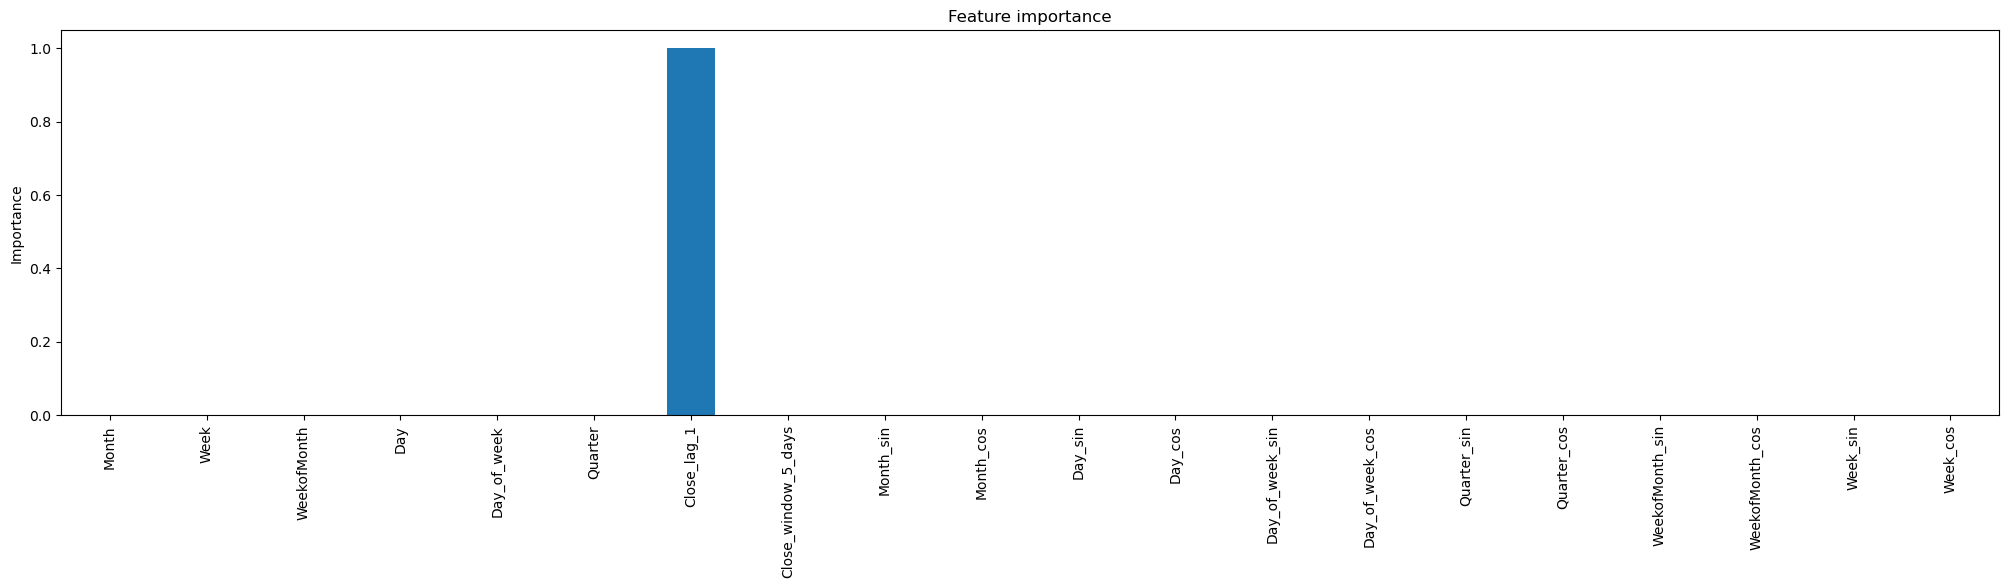

In [64]:
# Let's make a bar plot.
tmp.plot.bar(figsize=(25, 5))
plt.title("Feature importance")
plt.ylabel("Importance")

We can remark that the clost_lag_1 variable is the most important in predicting the following day's price of the S&P500 index.